In [262]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import statistics

In [263]:
df = pd.read_excel("real.xlsx")

In [264]:
df

,salary,exam,education
0,59634.52,93.42328,1
1,86653.05,100.00000,1
2,44618.66,54.54345,0
3,32816.56,48.42257,0
4,28589.03,41.49556,0
...,...,...,...
9995,30466.47,74.22810,0
9996,34741.11,36.40981,0
9997,111275.00,81.32597,1
9998,11666.88,37.15885,0


In [265]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   salary     10000 non-null  float64
 1   exam       10000 non-null  float64
 2   education  10000 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 234.5 KB


In [267]:
df['education'].corr(df['salary'])

0.36918865965720343

In [268]:
df["salary"].value_counts()

salary
0.00        90
49513.93     2
49359.49     2
71035.50     2
70434.42     2
            ..
93458.53     1
67309.08     1
38783.58     1
13103.36     1
21723.21     1
Name: count, Length: 9903, dtype: int64

In [269]:
df["exam"].value_counts()

exam
100.00000    119
0.00000        4
64.93453       2
42.94297       2
37.83628       2
            ... 
79.45353       1
87.29193       1
47.34735       1
52.00548       1
69.71146       1
Name: count, Length: 9870, dtype: int64

In [270]:
df["education"].value_counts()

education
0    8672
1    1328
Name: count, dtype: int64

<Axes: xlabel='exam', ylabel='salary'>

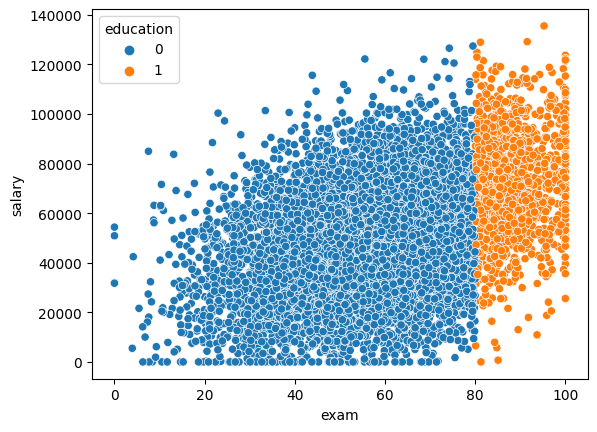

In [271]:
sns.scatterplot(
    x='exam', 
    y='salary', 
    data=df,
    hue='education')

<Axes: xlabel='exam', ylabel='salary'>

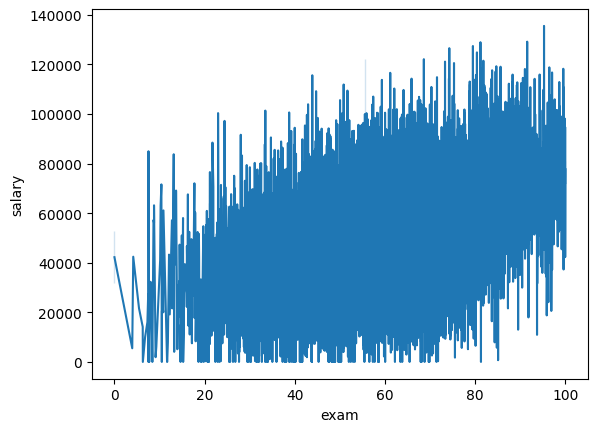

In [272]:
sns.lineplot(data=df, x="exam", y="salary")

In [273]:
agg_func = {
    'salary': ['mean', 'max', 'min']
}
df.groupby(['education']).agg(agg_func).round(2)

salary               
               mean       max  min
education                         
0          48342.02  127399.0  0.0
1          72477.03  135501.0  0.0

In [274]:
72477.03 - 48342.02

24135.010000000002

In [79]:
135501.0 - 127399.0

8102.0

In [275]:
0.0 - 0.0

0.0

Видим, что хоть и среднее отличается примерно на 23700, максимум и минимум по зарплате почти одинаковы. Все это + график указывают на наличие шумов и выбросов.

In [292]:
len(df)- len(df.drop_duplicates ())

0

Проверка на наличие дубликатов, которых в случае обнаружения следует убрать

Люди, которые имеет нулевую зарплату скорее всего пока не работают => тяжело оценить влияние образования на их будущую зарплату

In [276]:
new_df = df[df["salary"] > 0]

In [277]:
new_df

,salary,exam,education
0,59634.52,93.42328,1
1,86653.05,100.00000,1
2,44618.66,54.54345,0
3,32816.56,48.42257,0
4,28589.03,41.49556,0
...,...,...,...
9995,30466.47,74.22810,0
9996,34741.11,36.40981,0
9997,111275.00,81.32597,1
9998,11666.88,37.15885,0


<Axes: xlabel='exam', ylabel='salary'>

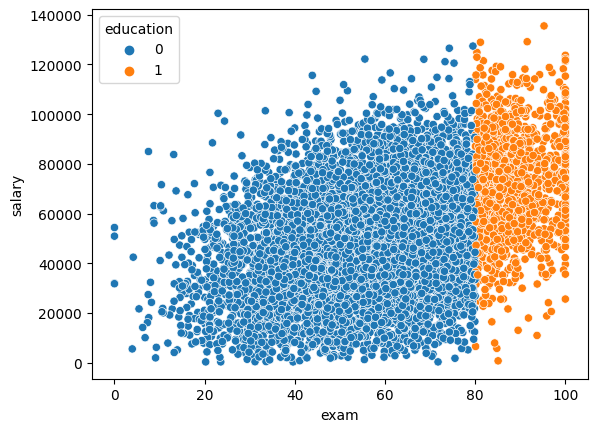

In [278]:
sns.scatterplot(
    x='exam', 
    y='salary', 
    data=new_df,
    hue='education')

<Axes: xlabel='exam', ylabel='salary'>

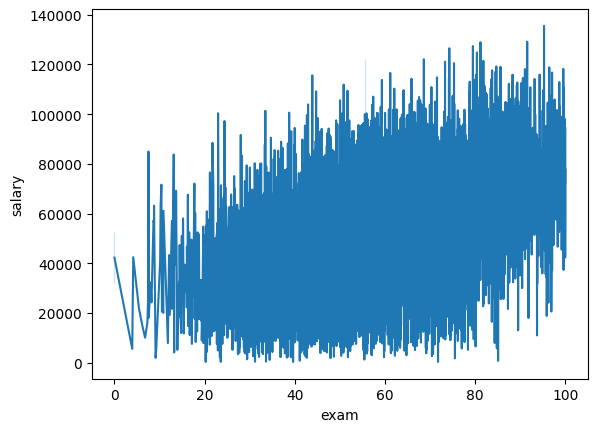

In [279]:
sns.lineplot(data=new_df, x="exam", y="salary")

Теперь избавимся от шумов и выбросов(разобьем людей на промежутки от 0 до 100 баллов с шагом 5, чтобы у нас не усреднилась метрика для всех участников(в ином случае алгоритм нормально сработает только для людей в центре графика(в районе 60 баллов))). Будем смотреть на отклонение от среднего. dev[i] = sqrt(abs(salary[i] - среднее salary по всем учатникам из промежутка)) - отклонение от нормы.

Далее будем подбирать параметр отклонения(больше которого брать в итоговую выборку не будем). Важно, чтобы мы не сильно много выкинули людей, чтобы выборка оставалась более объективной, а также нажно убрать как можно больше всяких резких линий на графике.

In [286]:
df_mer = pd.DataFrame()
STEP = 5
for i in range(0, 100, STEP):
    df_cur = new_df[(new_df['exam'] >= i) & (new_df['exam'] <= i+(STEP))]
    
    aver = df_cur["salary"].mean()
    
    df_cur.insert(loc=len(df_cur.columns), column='dev', value= (abs(df_cur["salary"] - aver) ** 0.5))
    
    df_cur = df_cur[(df_cur.dev < 215)]
    
    if len(df_mer) == 0:
        df_mer = df_cur
    else:
        df_mer = df_mer.merge(df_cur, how = 'outer')

<Axes: xlabel='exam', ylabel='salary'>

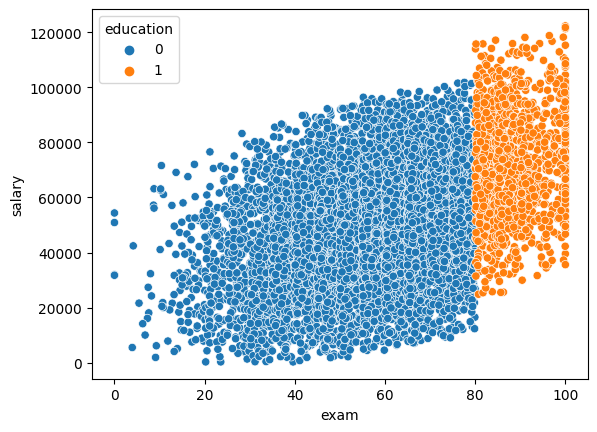

In [287]:
sns.scatterplot(
    x='exam', 
    y='salary', 
    data=df_mer,
    hue='education')

<Axes: xlabel='exam', ylabel='salary'>

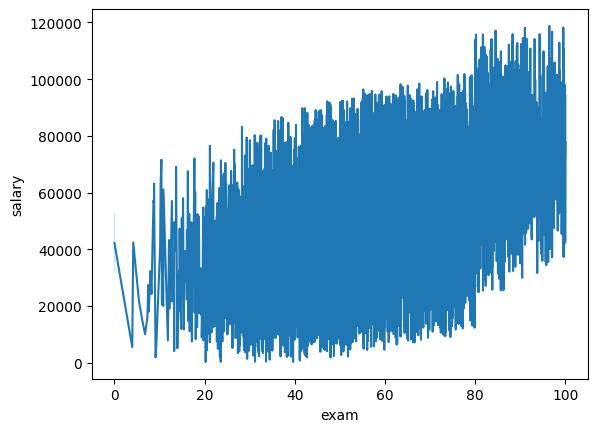

In [288]:
sns.lineplot(data=df_mer, x="exam", y="salary")

Как видно из графиков данные теперь являются более чистыми и гладкими, а также немного увеличилась корреляция между образованием и зарплатой.

In [289]:
len(df_mer)

9768

In [290]:
df_mer['education'].corr(df_mer['salary'])

0.3936572650796874

In [291]:
agg_func = {
    'salary': ['mean', 'max', 'min']
}
df_mer.groupby(['education']).agg(agg_func).round(2)

salary                    
               mean       max       min
education                              
0          48448.97  101803.7    269.67
1          72791.13  122302.6  24853.78

In [251]:
72791.13 - 48448.97

24342.160000000003

In [252]:
122302.6 - 101803.7

20498.90000000001

In [253]:
24853.78 - 269.67

24584.11

После очистки данных влияние высшего образования на зарплату стало более явным, что видно по среднему, а также по минимуму и максимуму в обоих случиях(без образования и с ним). В итоге можем сделать вывод, что высшее образование в данном датасете положительно влияет на зарплату(Примерно 24300 рублей в денежном эквиваленте)

Также следует отметить, что мат модель, приведенная в 2 части неплохо прогнозирует влияние высшего образования на данном для анализа датасете после чистки данных.